In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sm
import copy
from sympy.abc import *
sm.init_printing()
import fftrefm
reload(fftrefm)
from fftrefm import DDHOZ, DDHOZi, vary_dict, BLDS
from scipy import integrate, signal
from scipy.optimize import curve_fit
import tqdm
import sigutils
from sigutils._util import lin_or_logspace

In [2]:
params_full = dict(omega_0=2*np.pi*0.065,
             k=3.5,
             Q=26000.0,
             C=1e-3,
             C2q=0.65e-4,
             C2D=0.65e-4,
             Rs=200,
             Cs=1e-3,
             Vt=lambda t: 0)

T0 = (1/params_full['omega_0']) / (2*np.pi)
dt = T0/4
T = 20000
N = int(T/dt)
t = np.arange(N) * dt

params_full['Ci'] = 0.001
params_full['Ri'] = 300

fam = 160e-6

sim_params=dict(A=0.05, t=t)

ddhozi = DDHOZi(**params_full)

# # y0zi = np.array([0.00, 0, -1e-3*5, ])

In [3]:
Ris = np.array([60, 300, 300*5, 300*25])

In [4]:
bas = [fftrefm.tf2rc(**params) for params in vary_dict(params_full, 'Ri', Ris)]

In [5]:
zs = np.array([np.polyval(ba[0], (2*np.pi*0.065j)) / np.polyval(ba[1], (2*np.pi*0.065j)) for ba in bas])

In [6]:
params_dicts = list(vary_dict(params_full, 'Ri', Ris))

In [7]:
tot = 25
pbar = tqdm.tqdm_notebook(total=tot*len(Ris))
lds_s = [BLDS(3e-3, 2, tot, 5, fam, params, sim_params, pbar) for params in vary_dict(params_full, 'Ri', Ris)]

In [8]:
freqs = [lds.fms for lds in lds_s]
zs = [np.array(lds.out.z) for lds in lds_s]

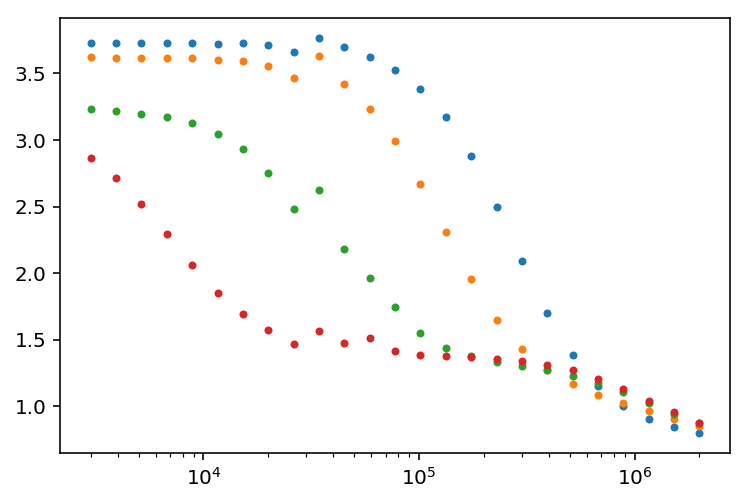

In [9]:
for freq,  z in zip(freqs, zs):
    plt.semilogx(freq*1e6, -z.real, '.')
#     plt.semilogx(freq, )

In [10]:
def blds_value(ba, fc, fm, C2q, C2D, Vm=1, k0=3.5):
    H = lambda f: np.polyval(ba[0], 2j*np.pi*f) / np.polyval(ba[1], 2j*np.pi*f)

    Hbar = (H(fm + fc) + H(fm-fc))/2
    return -fc * Vm**2 / (16 * k0) * (C2q + C2D * Hbar) * abs(H(fm))**2 * 1e6 # MHz to Hz

In [11]:
fc = params_full['omega_0']/(2*np.pi)
sim_freqs = np.array([blds_value(ba, fc, freq, params_full['C2q'], params_full['C2D'], 5, 3.5) for ba in bas])

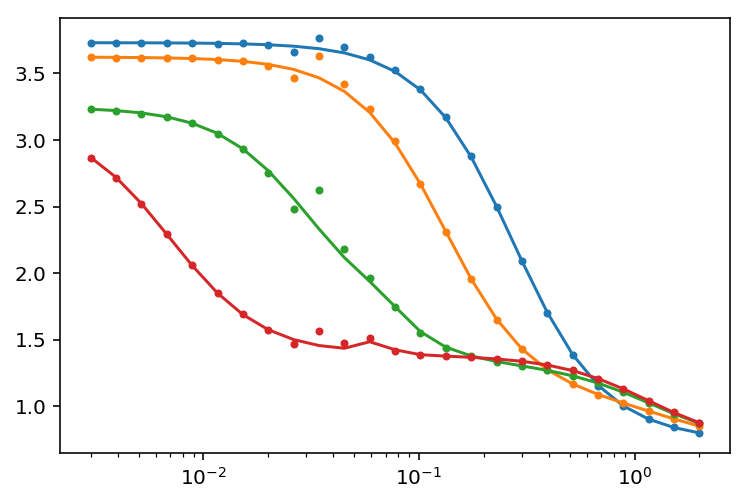

In [12]:
for freq,  z, sim_freq in zip(freqs, zs, sim_freqs):
    line, = plt.semilogx(freq, -z.real, '.')
    plt.semilogx(freq, -sim_freq.real, color=line.get_color(), linestyle='-')

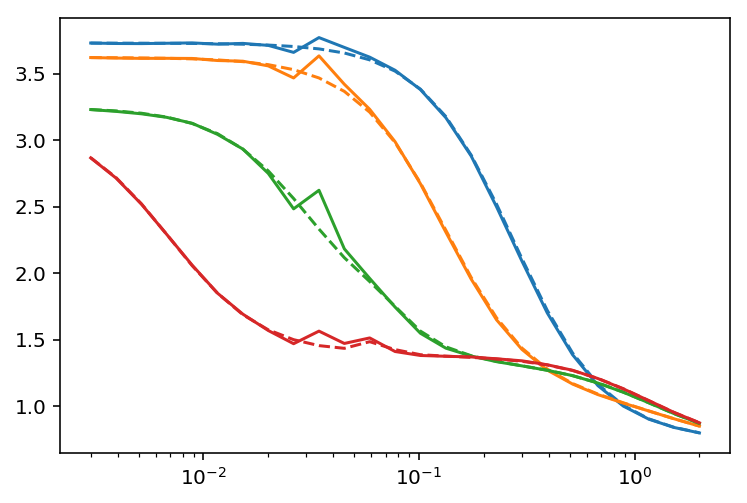

In [13]:
for freq,  z, sim_freq in zip(freqs, zs, sim_freqs):
    line, = plt.semilogx(freq, abs(z))
    plt.semilogx(freq, abs(sim_freq), color=line.get_color(), linestyle='--')

In [14]:
y_outs = [lds.out.y_out for lds in lds_s]
ddhos = [lds.ddhos for lds in lds_s]

# Saving results

In [16]:
import json_tricks
    
fh = open('../results/Fig14-blds-simulation.json', 'w')
readme = """
Readme
======
This file contains data for plots showing the results of simulating
the broadband local dielectric spectroscopy experiment.
We see good agreement with the impedance spectoscopy model.

The blds simulations were performed using the command:

    tot = 25
    pbar = tqdm.tqdm_notebook(total=tot*len(Ris))
    lds_s = [BLDS(3e-3, 2, tot, 5, fam, params, sim_params, pbar)
                for params in vary_dict(params_full, 'Ri', Ris)]

The modulation voltage was 5 volts (4th argument of LDS command) and
the amplitude modulation frequency was 160 Hz = 160e-6 MHz.

"""

params_full_no_V = copy.copy(params_full)
del params_full_no_V['Vt']

fh.write(json_tricks.dumps(dict(readme=readme,
                    freqs=freqs,
                    zs=zs,
                    sim_freqs=sim_freqs,
                    params_full=params_full_no_V,
                    sim_params=sim_params,
                    Ris=Ris,
                    bas=bas
                     ), indent=2))
fh.close()